In [271]:
import numpy as np
import osr_methods as osr
import line_search_methods as lsm
import matplotlib.pyplot as plt
from timeit import default_timer as timer

### Seleção da função

In [272]:
# 1 - Q1 letra a
# 2 - Q1 letra b
# 3 - Q2 letra a 
func = 2

def f(Xn):
    if (func == 1):
        return Xn[0]**2 - 3*Xn[0]*Xn[1] + 4*(Xn[1]**2) + Xn[0] - Xn[1]
    elif (func == 2):
        a = 10
        b = 1
        return (1 + a - b*Xn[0] - b*Xn[1])**2 + (b + Xn[0] + a*Xn[1] - b*Xn[0]*Xn[1])**2 
    elif (func == 3):
        return 450 *((np.sqrt((30 + Xn[0])**2 + Xn[1]**2) - 30 )**2) + 300 *((np.sqrt((30 - Xn[0])**2 + Xn[1]**2) - 30)**2) - 360*Xn[1]
def grad_f(Xn):
    if (func == 1):
        return np.array([2*Xn[0] - 3*Xn[1] + 1, -3*Xn[0] + 8*Xn[1] - 1])
    elif (func == 2):
        a = 10;
        b = 1;
        return np.array([2*(-a*(b*(Xn[1]**2) + b - Xn[1]) + (b**2)*Xn[0]*(Xn[1]**2 + 1) - 2*b*Xn[0]*Xn[1] + Xn[0]),
                        -2*b*(2*a*Xn[0]*Xn[1] + Xn[0]**2 + 1) + 2*a*(a*Xn[1] + Xn[0]) + 2*(b**2)*(Xn[0]**2 + 1)*Xn[1]])
    elif (func == 3):
        return np.array([(900*(Xn[0] + 30)*(np.sqrt((Xn[0] + 30)**2 + Xn[1]**2) - 30))/np.sqrt((Xn[0] + 30)**2 + Xn[1]**2) - (600*(30 - Xn[0])*(np.sqrt((Xn[0] - 30)**2 + Xn[1]**2) - 30))/np.sqrt((Xn[0] - 30)**2 + Xn[1]**2),
                        60*(Xn[1]*(-450/np.sqrt(Xn[0]**2 + 60*Xn[0] + Xn[1]**2 + 900) - 300/np.sqrt(Xn[0]**2 - 60*Xn[0] + Xn[1]**2 + 900) + 25) - 6)])
def hessian_f(Xn):
    if (func == 1):
        return np.array([[2, -3],
                       [-3, 8]], dtype=float)
    elif (func == 2):
        a = 10;
        b = 1;
        hessian = np.zeros((2,2))
        hessian[0, 0] = 2*(b**2) + 2*((1 - b*Xn[1])**2)
        hessian[0, 1] = -2*b*(a*Xn[1] + b*(-Xn[0]*Xn[1]) + b + Xn[0]) + 2*(1-b*Xn[1])*(a - b*Xn[0]) + 2*(b**2)
        hessian[1, 0] = -2*b*(a*Xn[1] + b*(-Xn[0]*Xn[1]) + b + Xn[0]) + 2*(1-b*Xn[1])*(a-b*Xn[0]) + 2*(b**2)
        hessian[1, 1] = 2*((a-b*Xn[0])**2) + 2*(b**2)
        return hessian

### Seleção do ponto inicial

In [273]:
if (func == 1):
    P0 = np.array([2, 2])
    #P0 = [-1, -3]
    n_func = 'Q1.a'
elif (func == 2):
    #P0 = np.array([10, 2])
    P0 = np.array([-2, -3])
    n_func = 'Q1.b'
elif (func == 3):
    P0 = np.array([0.01, -0.1])
    n_func = 'Q2.a'

### Controle Numérico

In [274]:
maxiter = 200
tol_conv = 0.00001
tol_search = 0.00000001
line_step = 0.001

### Seleção do Método de OSR

In [275]:
# 1 - Univariante
# 2 - Powell
# 3 - Steepest Descent
# 4 - Newton Raphson
# 5 - Fletcher Reeves
# 6 - BFGS

metodo = 1

if (metodo == 1):
    n_met = 'Univariante'
elif (metodo == 2):
    n_met = 'Powell'
elif (metodo == 3):
    n_met = 'Steepest Descent'
elif (metodo == 4):
    n_met = 'Newton Raphson'
elif (metodo == 5):
    n_met = 'Fletcher-Reeves'
elif (metodo == 6):
    n_met = 'BFGS'

### Inicializações

In [276]:
passos = 0
dimens = P0.size
Pmin = P0.copy()
listPmin = []
listPmin.append(Pmin)
grad = grad_f(Pmin)
norm_grad = np.linalg.norm(grad)

if (metodo == 2):
    direcoes = np.eye(dimens, dtype=float)
    ciclos = 0
    P1 = P0.copy()
elif (metodo == 5):
    #o metodo recebe a direcao anterior 
    #inicializo a direcao com um vetor de zeros mas que nunca e usado
    #uso apenas para enviar como parametro na primeira iteracao do metodo, o qual atualiza o valor de dir para a iteracao seguinte
    dir = np.zeros((1, dimens))
    grad_last = grad.copy()
elif(metodo == 6):
    S_last = np.eye(dimens)
    grad_last = grad.copy()
    P_last = P0.copy()

### Cálculo do Ponto Mínimo

In [277]:
start = timer()
while (norm_grad > tol_conv):
    if (passos == maxiter):
        print('Nao convergiu')
        break
    passos = passos + 1
    if (metodo == 1):
        dir = osr.univariante(passos, dimens)
    elif (metodo == 2):
        dir, direcoes, P1, ciclos = osr.powell(Pmin, P1, direcoes,passos, ciclos, dimens)
    elif (metodo == 3):
        dir = osr.steepestDescent(grad)
    elif (metodo == 4):
        dir = osr.newtonRaphson(Pmin, grad, hessian_f)
    elif (metodo == 5):
        dir, grad_last = osr.fletcherReeves(dir, grad, grad_last, passos)
    elif (metodo == 6):
        dir, P_last, grad_last, S_last = osr.bfgs(Pmin, P_last, grad, grad_last, S_last, passos, dimens)
        
    intervalo = lsm.passo_cte(dir, Pmin, f, line_step)
    alpha = lsm.secao_aurea(intervalo, dir, Pmin, f, tol_search)
    Pmin = Pmin + alpha*dir
    listPmin.append(Pmin)
    grad = grad_f(Pmin)
    norm_grad = np.linalg.norm(grad)
    print(f'Passo{passos}, Pmin={Pmin}, d={dir}')

end = timer()

tempoExec = end - start
print(f'tempo= {tempoExec}')


Passo1, Pmin=[ 7.64705881 -3.        ], d=[1. 0.]
Passo2, Pmin=[ 7.64705881 -2.59978826], d=[0. 1.]
Passo3, Pmin=[ 7.42105881 -2.59978826], d=[1. 0.]
Passo4, Pmin=[ 7.42105881 -2.37075177], d=[0. 1.]
Passo5, Pmin=[ 7.2730588  -2.37075177], d=[1. 0.]
Passo6, Pmin=[ 7.2730588  -2.23242518], d=[0. 1.]
Passo7, Pmin=[ 7.17656922 -2.23242518], d=[1. 0.]
Passo8, Pmin=[ 7.17656922 -2.1470195 ], d=[0. 1.]
Passo9, Pmin=[ 7.11356921 -2.1470195 ], d=[1. 0.]
Passo10, Pmin=[ 7.11356921 -2.0930195 ], d=[0. 1.]
Passo11, Pmin=[ 7.07256921 -2.0930195 ], d=[1. 0.]
Passo12, Pmin=[ 7.07256921 -2.05901398], d=[0. 1.]
Passo13, Pmin=[ 7.0465692  -2.05901398], d=[1. 0.]
Passo14, Pmin=[ 7.0465692  -2.03764856], d=[0. 1.]
Passo15, Pmin=[ 7.0295692  -2.03764856], d=[1. 0.]
Passo16, Pmin=[ 7.0295692  -2.02364856], d=[0. 1.]
Passo17, Pmin=[ 7.01856919 -2.02364856], d=[1. 0.]
Passo18, Pmin=[ 7.01856919 -2.01464855], d=[0. 1.]
Passo19, Pmin=[ 7.01156919 -2.01464855], d=[1. 0.]
Passo20, Pmin=[ 7.01156919 -2.00927947],

### Plot

Q1.b_Univariante_P0=[-2 -3].pdf


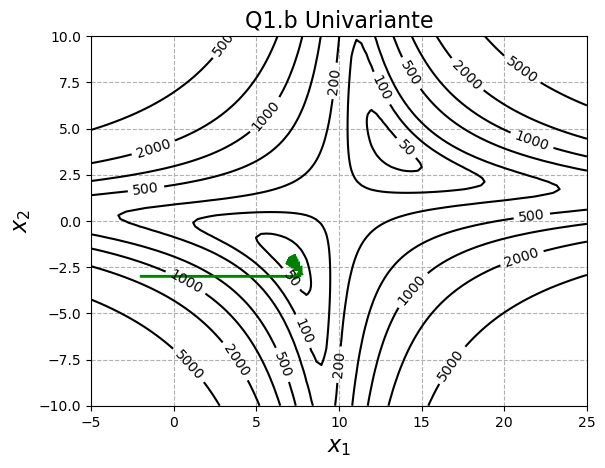

In [278]:
if (func == 1):
    x1 = np.linspace(-2, 3, 100)
    x2 = np.linspace(-1, 2.5, 100)
    X1, X2 = np.meshgrid(x1, x2)
    X3 = f([X1, X2])
    niveis = plt.contour(X1, X2, X3, [-0.2, 0, 1, 3, 6, 10, 25], colors='black')
elif (func == 2):
    x1 = np.linspace(-5, 25, 100)
    x2 = np.linspace(-10, 10, 100)
    X1, X2 = np.meshgrid(x1, x2)
    X3 = f([X1, X2])
    niveis = plt.contour(X1, X2, X3,[50, 100,200,500, 1000, 2000, 5000], colors='black')
elif (func == 3):
    x1 = np.linspace(-3, 3, 100)
    x2 = np.linspace(-6, 15, 100)
    X1, X2 = np.meshgrid(x1, x2)
    X3 = f([X1, X2])
    niveis = plt.contour(X1, X2, X3,[-2000,-1500, -1000, -500,500,2000], colors='black')    
    


plt.clabel(niveis, inline=1, fontsize=10)

for i in np.arange(len(listPmin)-1):
    plt.annotate('', xy=listPmin[i+1], xytext=listPmin[i],
                arrowprops=dict(width=1, color='green', headwidth=4, headlength=4, shrink=0.0), fontsize='10')
#    #plt.plot(pontos[i][0], pontos[i][1], marker="o", markersize=7, markeredgecolor="green", markerfacecolor="green")
#    #plt.plot(pontos[i+1][0], pontos[i+1][1], marker="o", markersize=1, markeredgecolor="green", markerfacecolor="green")
plt.xlabel('$x_1$', fontsize='16')
plt.ylabel('$x_2$', fontsize='16')
plt.grid(linestyle='--')
titulo = n_func + ' ' + n_met
plt.title(titulo, fontsize='16')
file_name = n_func + '_' + n_met + '_P0=' + np.array2string(P0, precision = 2, separator=' ') + '.pdf'
plt.savefig(file_name, format="pdf")
plt.show()